In [19]:
import numpy as np
import pandas as pd
import cvxpy as cp
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# --------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------

df_info = pd.read_csv('selected_esg_scores.csv')
df_price = pd.read_csv('yahoo_all_stocks_10y_merged.csv')

df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price = df_price.set_index('Date', inplace=False)

# Ensure tickers exist
tickers = df_info['Ticker'].dropna().unique().tolist()
missing = [t for t in tickers if t not in df_price.columns]
if missing:
    print("Missing tickers:", missing)
    tickers = [t for t in tickers if t in df_price.columns]

df_price = df_price[tickers].astype(float)

# --------------------------------------------------
# 2. RETURNS & COVARIANCE
# --------------------------------------------------

df_return = np.log(df_price / df_price.shift(1)).dropna()
df_return = df_return[tickers]

df_cov = df_return.cov()

# Filter df_info
df_info = df_info[df_info["Ticker"].isin(df_return.columns)].copy()

# --------------------------------------------------
# 3. METRICS
# --------------------------------------------------

mu = df_return.mean() * 252                      # annualized return
sigma = df_return.std() * np.sqrt(252)           # annualized volatility

df_metrics = pd.DataFrame({
    "Ticker": df_return.columns,
    "Return": mu.values,
    "Volatility": sigma.values
})

df_ahp = df_info.merge(df_metrics, on="Ticker")

# --------------------------------------------------
# 4. SIMPLE AHP FUNCTIONS
# --------------------------------------------------

def simple_ahp_weights(A):
    """Compute criteria weights using Simple AHP"""
    col_sum = A.sum(axis=0)
    norm_A = A / col_sum
    weights = norm_A.mean(axis=1)
    return weights / weights.sum()

def normalize_criteria(df, types):
    """Min–max normalization with benefit/cost handling"""
    df_norm = df.copy()
    for col, t in zip(df.columns, types):
        if t == 1:  # benefit
            df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min() + 1e-12)
        else:       # cost
            df_norm[col] = (df[col].max() - df[col]) / (df[col].max() - df[col].min() + 1e-12)
    return df_norm

# --------------------------------------------------
# 5. AHP CRITERIA WEIGHTS (PAIRWISE COMPARISON)
# --------------------------------------------------
# Order: [ESG, Return, Volatility]

# A = np.array([
#     [1,   2,   4],
#     [1/2, 1,   3],
#     [1/4, 1/3, 1]
# ])

# refer here
w = np.array([0.4, 0.35, 0.25])

A = np.array([
    [1,         w[0]/w[1], w[0]/w[2]],
    [w[1]/w[0], 1,         w[1]/w[2]],
    [w[2]/w[0], w[2]/w[1], 1]
])

weights = simple_ahp_weights(A)
print("AHP criteria weights:", weights)

# Benefit (+1) / Cost (-1)
types = np.array([1, 1, -1])

# --------------------------------------------------
# 6. AHP SCORING
# --------------------------------------------------

criteria = df_ahp[["ESG_Score", "Return", "Volatility"]].astype(float)
criteria_norm = normalize_criteria(criteria, types)

df_ahp["AHP_score"] = criteria_norm.values @ weights

# --------------------------------------------------
# 7. ASSET SELECTION
# --------------------------------------------------

# top_n = 30
# selected_tickers = (
#     df_ahp
#     .sort_values("AHP_score", ascending=False)
#     .head(top_n)["Ticker"]
#     .tolist()
# )

selected_tickers = df_ahp[df_ahp["AHP_score"] > 0.6]["Ticker"].tolist()

print("Number of selected tickers:", len(selected_tickers))

df_info_sel = df_info[df_info["Ticker"].isin(selected_tickers)].copy()
df_return_sel = df_return[selected_tickers]

df_cov_sel = df_return_sel.cov()
mu_sel = df_return_sel.mean() * 252

# --------------------------------------------------
# 8. MARKOWITZ INPUTS
# --------------------------------------------------

n_assets = len(selected_tickers)
ones_vec = np.ones(n_assets)

mu_np = mu_sel.values
Sigma = df_cov_sel.values * 252
Sigma = 0.5 * (Sigma + Sigma.T)
Sigma += np.eye(n_assets) * 1e-6

Sigma_inv = np.linalg.inv(Sigma)

# --------------------------------------------------
# 9. MINIMUM VARIANCE PORTFOLIO
# --------------------------------------------------

w_min = Sigma_inv @ ones_vec / (ones_vec @ Sigma_inv @ ones_vec)
r_min = w_min @ mu_np

print("Minimum variance return:", r_min)
print("Minimum variance weights:\n", w_min)

# --------------------------------------------------
# 10. EFFICIENT FRONTIER
# --------------------------------------------------

Sigma_np = Sigma
n = len(mu_np)

frontier = []

w = cp.Variable(n)
target_return_param = cp.Parameter()

prob = cp.Problem(
    cp.Minimize(cp.quad_form(w, Sigma_np)),
    [
        cp.sum(w) == 1,
        w @ mu_np == target_return_param,
        w >= 0.0001,
        w <= 1
    ]
)

for tr in tqdm(np.linspace(mu_np.min(), mu_np.max(), 100), desc="Building frontier"):
    target_return_param.value = tr
    try:
        prob.solve(solver=cp.OSQP, warm_start=True)
        if prob.status == cp.OPTIMAL:
            w_val = w.value
            frontier.append({
                "target_return": tr,
                "achieved_return": float(w_val @ mu_np),
                "variance": float(cp.quad_form(w_val, Sigma_np).value),
                "stdev": np.sqrt(float(cp.quad_form(w_val, Sigma_np).value)),
                "weights": w_val
            })
    except Exception:
        continue

frontier_df = pd.DataFrame(frontier)


AHP criteria weights: [0.4  0.35 0.25]
Number of selected tickers: 30
Minimum variance return: 0.10556262839716252
Minimum variance weights:
 [ 0.07141318  0.06628377  0.0506704   0.01701979 -0.0165758   0.02796194
  0.08282169  0.03624997 -0.00155197 -0.01168483  0.05459222  0.03480491
  0.07283829  0.0057699   0.01852425  0.10899352  0.0049637   0.09068642
  0.15320942 -0.15970996 -0.0345098   0.03425484  0.0108483   0.01981967
 -0.02774033 -0.00223584  0.08585426 -0.06301497  0.1699789   0.09946418]


Building frontier: 100%|██████████| 100/100 [00:00<00:00, 664.55it/s]


In [20]:
print(selected_tickers)

['ABBV', 'AMZN', 'ATO', 'CAT', 'CVX', 'DTE', 'FTV', 'GD', 'GE', 'HCA', 'JPM', 'LLY', 'LMT', 'META', 'MMM', 'MO', 'NRG', 'PCAR', 'PG', 'PH', 'PSX', 'PWR', 'SHW', 'SO', 'STLD', 'TDG', 'TSN', 'WFC', 'WMT', 'XOM']


In [21]:
frontier_df['weights']

0     [9.892803206306054e-05, 9.879506300714311e-05,...
1     [0.00010122627837789034, 0.0001013645287091284...
2     [0.00010148404425637623, 0.0001016513550494439...
3     [0.00010171557631085749, 0.0001019089899692143...
4     [0.00010213191912372667, 0.0001023722711790343...
                            ...                        
93    [9.64244731803264e-05, 9.681227241202568e-05, ...
94    [9.855712795184905e-05, 9.871362090118e-05, 9....
95    [9.938538901716418e-05, 9.944312317462803e-05,...
96    [9.964101150812978e-05, 9.967473345585143e-05,...
97    [9.973661357245847e-05, 9.976135505544235e-05,...
Name: weights, Length: 98, dtype: object

In [22]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# ---------------------------
# 1. Inputs from your pipeline
# ---------------------------
mu = mu_sel.values                               # annualized return vector
Sigma = df_cov_sel.values * 252                  # annualized covariance matrix
n_assets = len(mu)

# If covariance is singular, add tiny noise
Sigma += np.eye(n_assets) * 1e-6

# ---------------------------
# 2. Analytical Frontier
# ---------------------------
inv_sigma = np.linalg.pinv(Sigma)
ones = np.ones(n_assets)

A = ones @ inv_sigma @ mu
B = mu @ inv_sigma @ mu
C = ones @ inv_sigma @ ones
D = B * C - A**2

m = np.linspace(mu.min(), mu.max(), 100)
Sigma_m = np.sqrt((C / D) * (m - A / C) ** 2 + 1 / C)

# ---------------------------
# 3. Global Random Portfolios
# ---------------------------
num_port_global = 100000
alpha = 0.0005

weights_global = np.random.dirichlet(np.full(n_assets, alpha), num_port_global)

port_returns_1 = weights_global @ mu
port_vars_1 = np.einsum('ij,jk,ik->i', weights_global, Sigma, weights_global)
port_stdevs_1 = np.sqrt(port_vars_1)

port_df_1 = pd.DataFrame({
    'Volatility': port_stdevs_1,
    'Return': port_returns_1
})

# ---------------------------
# 4. Frontier-Focused Sampling (Stratified)
# ---------------------------
# Ensure frontier_df exists
W_front = np.array(frontier_df["weights"].tolist())
eps = 1e-7

num_port_strat = 5000
n_bins = len(frontier_df)
n_per_bin = num_port_strat // n_bins

kappa_min, kappa_max = 1, 100000.0
n_kappa_levels = 20

kappa_vals = np.geomspace(kappa_min, kappa_max, n_kappa_levels)
kappa_wts = 1.0 / (kappa_vals**1 + 1e-12)
kappa_wts /= kappa_wts.sum()

weights_list = []

for i in range(n_bins):
    sizes = np.floor(n_per_bin * kappa_wts).astype(int)
    leftover = n_per_bin - sizes.sum()
    if leftover > 0:
        sizes[:leftover] += 1

    for kappa, sz in zip(kappa_vals, sizes):
        if sz > 0:
            alphas_i = kappa * (W_front[i] + eps)
            weights_list.append(np.random.dirichlet(alphas_i, sz))

weights_strat = np.vstack(weights_list)

port_returns_2 = weights_strat @ mu
port_vars_2 = np.einsum('ij,jk,ik->i', weights_strat, Sigma, weights_strat)
port_stdevs_2 = np.sqrt(port_vars_2)

port_df_2 = pd.DataFrame({
    'Volatility': port_stdevs_2,
    'Return': port_returns_2
})

# ---------------------------
# 5. Combine
# ---------------------------
port_df = pd.concat([port_df_1, port_df_2], ignore_index=True)


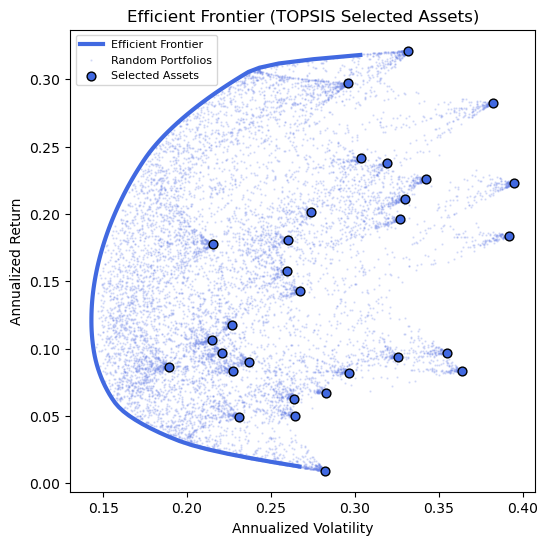

In [23]:
plt.figure(figsize=(6, 6))

# Efficient Frontier from CVXPY
plt.plot(
    frontier_df["stdev"],
    frontier_df["achieved_return"],
    color='royalblue',
    linewidth=3,
    label="Efficient Frontier"
)

# Global + Stratified random portfolios
plt.scatter(
    port_df['Volatility'],
    port_df['Return'],
    s=0.5,
    c='#6881E7',
    alpha=0.2,
    label="Random Portfolios"
)

# Individual selected assets (tickers)
asset_returns = mu_sel.values
asset_stdevs = df_return_sel.std(axis=0) * np.sqrt(252)

plt.scatter(
    asset_stdevs,
    asset_returns,
    facecolors='royalblue',
    edgecolors='k',
    linewidths=1,
    s=40,
    label="Selected Assets"
)

plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier (TOPSIS Selected Assets)")
plt.legend(loc='best', fontsize=8)

plt.savefig('AHP/Portfolio_Frontier.png', dpi=144, transparent=True)
plt.show()


In [24]:
## MIQP (actually continuous relaxation)
esg_min = 30
max_w_per_asset = 0.20
min_w_if_selected = 0.0001
max_w_per_sector = 0.25
min_n_assets = 5

# Align info
df_info_sel = df_info_sel.set_index("Ticker").loc[selected_tickers].reset_index()

esg_sel = df_info_sel["ESG_Score"].values
sectors_sel = df_info_sel["Category"].tolist()
unique_sectors_sel = sorted(set(sectors_sel))

In [25]:
# Data prep
mu_np = np.array(mu_sel).flatten()
Sigma_np = np.array(df_cov_sel) * 252
Sigma_np = (Sigma_np + Sigma_np.T) / 2

esg_np = np.array(esg_sel).flatten()
n_assets = len(mu_np)

frontier_esg = []
grid = np.linspace(mu_np.min(), mu_np.max(), 30)

sector_masks = [
    np.array([1 if sct == sec else 0 for sct in sectors_sel])
    for sec in unique_sectors_sel
]

for tr in tqdm(grid, desc="Building ESG frontier"):

    w = cp.Variable(n_assets)
    y = cp.Variable(n_assets)  # continuous relaxation

    risk = cp.quad_form(w, cp.psd_wrap(Sigma_np))

    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        mu_np @ w >= tr,            # <-- use >= not ==
        esg_np @ w >= esg_min,

        # selection constraints (continuous)
        y >= 0,
        y <= 1,
        cp.sum(y) >= min_n_assets,
        w <= y,
        w >= min_w_if_selected * y,

        # max weight per asset
        w <= max_w_per_asset
    ]

    for mask in sector_masks:
        constraints.append(mask @ w <= max_w_per_sector)

    objective = cp.Minimize(risk + 0.001 * cp.sum(y))

    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.OSQP, warm_start=True)

        if prob.status == cp.OPTIMAL:
            w_val = np.array(w.value).flatten()
            w_val[w_val < 1e-6] = 0

            p_ret = float(mu_np @ w_val)
            p_var = float(w_val @ Sigma_np @ w_val)

            frontier_esg.append({
                "target_return": tr,
                "achieved_return": p_ret,
                "variance": p_var,
                "stdev": np.sqrt(p_var),
                "weights": w_val
            })
    except Exception as e:
        print(f"Solver Error: {e}")
        continue

frontier_esg_df = pd.DataFrame(frontier_esg)

Building ESG frontier:  80%|████████  | 24/30 [00:00<00:00, 124.31it/s]/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Building ESG frontier: 100%|██████████| 30/30 [00:00<00:00, 115.54it/s]


In [26]:
frontier_esg_df['weights']

0     [0.10411473207859857, 0.0816002715344258, 0.10...
1     [0.10411473207859857, 0.0816002715344258, 0.10...
2     [0.10411473207859857, 0.0816002715344258, 0.10...
3     [0.10411473207859857, 0.0816002715344258, 0.10...
4     [0.10411473207859857, 0.0816002715344258, 0.10...
5     [0.10411473207859857, 0.0816002715344258, 0.10...
6     [0.10411473207859857, 0.0816002715344258, 0.10...
7     [0.10411473207859857, 0.0816002715344258, 0.10...
8     [0.10411473207859857, 0.0816002715344258, 0.10...
9     [0.10411473207859857, 0.0816002715344258, 0.10...
10    [0.10411473207859857, 0.0816002715344258, 0.10...
11    [0.10411473207859857, 0.0816002715344258, 0.10...
12    [0.10649972852057994, 0.08258824980222973, 0.1...
13    [0.11064112483232211, 0.0826194148834649, 0.10...
14    [0.11334647296707483, 0.08092674287585802, 0.1...
15    [0.1150723884522036, 0.07686681559884818, 0.11...
16    [0.11624974507503544, 0.07155614165068899, 0.1...
17    [0.10766048666529188, 0.06740769274306138,

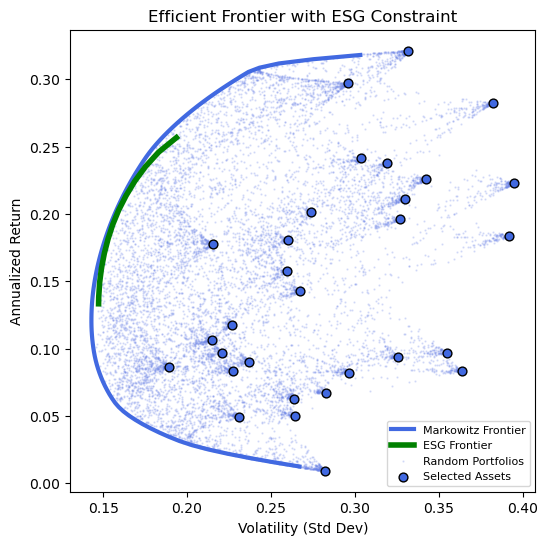

In [27]:
# --- asset stats for TOPSIS selected tickers ---
asset_returns = mu_sel.values
asset_stdevs = df_return_sel.std(axis=0) * np.sqrt(252)

plt.figure(figsize=(6, 6))

# efficient frontier without ESG
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"],
         color='royalblue', linewidth=3, label="Markowitz Frontier")

# efficient frontier with ESG
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"],
         color='green', linewidth=4, label="ESG Frontier")

# scatter of random portfolios
plt.scatter(port_df['Volatility'], port_df['Return'],
            s=0.5, c='#6881E7', alpha=0.2, label="Random Portfolios")

# scatter of individual assets (TOPSIS selected)
plt.scatter(asset_stdevs, asset_returns,
            facecolors='royalblue', edgecolors='k', linewidths=1, s=40,
            label="Selected Assets")

plt.legend(loc='best', fontsize=8)
plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier with ESG Constraint")

plt.savefig('AHP/Portfolio_Frontier_ESG.png', dpi=144, transparent=True)
plt.show()


In [28]:
esg_max = 30

In [29]:
# ---------------------------------------------------
# Brown / Low-ESG Efficient Frontier (Relaxed)
# ---------------------------------------------------

esg_max = 30                 # LOW ESG threshold (Brown)
max_w_per_asset = 0.20
min_w_if_selected = 0.0001
max_w_per_sector = 0.25
min_n_assets = 5

# --- DATA SETUP (TOPSIS-selected universe) ---
mu_np = mu_sel.values
Sigma_np = df_cov_sel.values * 252
Sigma_np = (Sigma_np + Sigma_np.T) / 2

esg_np = esg_sel
sectors = sectors_sel
unique_sectors = unique_sectors_sel

n_assets = len(mu_np)

# Safety: small diagonal ridge
Sigma_np += np.eye(n_assets) * 1e-6

# Precompute sector masks
sector_masks = [
    np.array([1 if sct == sec else 0 for sct in sectors])
    for sec in unique_sectors
]

frontier_brown = []

# Target return grid
grid = np.linspace(mu_np.min(), mu_np.max() * 0.9, 30)

# --- Optimization Loop ---
for tr in tqdm(grid, desc="Building Brown (Low-ESG) Frontier"):

    w = cp.Variable(n_assets)
    y = cp.Variable(n_assets)   # continuous relaxation

    risk = cp.quad_form(w, cp.psd_wrap(Sigma_np))

    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        mu_np @ w >= tr,
        esg_np @ w <= esg_max,          # LOW ESG constraint

        # selection constraints
        y >= 0,
        y <= 1,
        cp.sum(y) >= min_n_assets,
        w <= y,
        w >= min_w_if_selected * y,

        # max per asset
        w <= max_w_per_asset
    ]

    # sector caps
    for mask in sector_masks:
        constraints.append(mask @ w <= max_w_per_sector)

    objective = cp.Minimize(risk + 0.001 * cp.sum(y))

    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.OSQP, warm_start=True)

        if prob.status == cp.OPTIMAL:
            w_val = np.array(w.value).flatten()
            w_val[w_val < 1e-6] = 0

            p_ret = float(mu_np @ w_val)
            p_var = float(w_val @ Sigma_np @ w_val)

            frontier_brown.append({
                "target_return": tr,
                "achieved_return": p_ret,
                "variance": p_var,
                "stdev": np.sqrt(p_var),
                "weights": w_val
            })

    except Exception as e:
        print(f"Solver error at tr={tr:.4f}: {e}")
        continue

frontier_brown_df = pd.DataFrame(frontier_brown)


Building Brown (Low-ESG) Frontier: 100%|██████████| 30/30 [00:00<00:00, 147.30it/s]


In [30]:
# plt.figure(figsize=(6, 6))

# # --- Markowitz frontier (no ESG) ---
# plt.plot(
#     frontier_df["stdev"],
#     frontier_df["achieved_return"],
#     color="royalblue",
#     linewidth=3,
#     label="Markowitz Frontier"
# )

# # --- Brown (Low-ESG) frontier ---
# plt.plot(
#     frontier_brown_df["stdev"],
#     frontier_brown_df["achieved_return"],
#     color="saddlebrown",
#     linewidth=4,
#     label="Brown (Low-ESG) Frontier"
# )

# # --- Random portfolios ---
# plt.scatter(
#     port_df["Volatility"],
#     port_df["Return"],
#     s=0.5,
#     alpha=0.2,
#     label="Random Portfolios"
# )

# # --- Individual assets (TOPSIS-selected) ---
# plt.scatter(
#     asset_stdevs,
#     asset_returns,
#     facecolors="royalblue",
#     edgecolors="k",
#     linewidths=1,
#     s=40,
#     label="Selected Assets"
# )

# plt.xlabel("Annualized Volatility")
# plt.ylabel("Annualized Return")
# plt.title("Efficient Frontier with Brown (Low-ESG) Constraint")
# plt.legend(loc='best', fontsize=8)
# plt.grid(alpha=0.2)

# plt.tight_layout()
# plt.savefig("AHP/Portfolio_Frontier_ESG_Brown.png", dpi=144, transparent=True)
# plt.show()


In [31]:
# ---------------------------------------------------
# Sort ESG frontiers for correct plotting
# ---------------------------------------------------

frontier_esg_df = (
    frontier_esg_df
    .dropna()
    .sort_values(by="achieved_return", ascending=True)
    .reset_index(drop=True)
)

frontier_brown_df = (
    frontier_brown_df
    .dropna()
    .sort_values(by="achieved_return", ascending=True)
    .reset_index(drop=True)
)


In [32]:
# ============================================================
# Tangency Portfolios (Maximum Sharpe Ratio)
# ============================================================

rf = 0.00012 *252  # annualized risk-free rate (keep consistent)

asset_cols = df_return_sel.columns.tolist()
os.makedirs("AHP/Tangency", exist_ok=True)

def scalarize(x):
    """Convert arrays/lists to a single scalar float."""
    arr = np.array(x).ravel()
    if arr.size == 0:
        return np.nan
    return float(arr[0])

def vectorize_weights(w):
    """Convert weights to 1D numpy array."""
    if isinstance(w, str):
        w = w.strip("[]")
        w = np.array(w.split(), dtype=float)
    else:
        w = np.array(w).ravel()
    return w.astype(float)

def compute_tangency(frontier_df, rf):
    df = frontier_df.copy()

    # Force scalar values
    df["stdev"] = pd.to_numeric(df["stdev"], errors="coerce")
    df["achieved_return"] = pd.to_numeric(df["achieved_return"], errors="coerce")

    # Compute Sharpe
    df["sharpe"] = (df["achieved_return"] - rf) / df["stdev"]

    # ONLY clean sharpe column (no replace on full df)
    df = df[np.isfinite(df["sharpe"])]

    idx = df["sharpe"].idxmax()

    w = vectorize_weights(df.loc[idx, "weights"])
    ret = float(df.loc[idx, "achieved_return"])
    vol = float(df.loc[idx, "stdev"])
    sharpe = float(df.loc[idx, "sharpe"])

    return w, ret, vol, sharpe


# ------------------------------------------------------------
# Tangency portfolios
# ------------------------------------------------------------
tan_w, tan_ret, tan_vol, tan_sharpe = compute_tangency(frontier_df, rf)
tan_w_esg, tan_ret_esg, tan_vol_esg, tan_sharpe_esg = compute_tangency(frontier_esg_df, rf)
tan_w_b, tan_ret_b, tan_vol_b, tan_sharpe_b = compute_tangency(frontier_brown_df, rf)

# ------------------------------------------------------------
# Export weights
# ------------------------------------------------------------
pd.DataFrame({"asset": asset_cols, "weight": tan_w}).to_csv(
    "AHP/Tangency/tangency_markowitz_weights.csv", index=False)

pd.DataFrame({"asset": asset_cols, "weight": tan_w_esg}).to_csv(
    "AHP/Tangency/tangency_green_weights.csv", index=False)

pd.DataFrame({"asset": asset_cols, "weight": tan_w_b}).to_csv(
    "AHP/Tangency/tangency_brown_weights.csv", index=False)

# ------------------------------------------------------------
# Export summaries
# ------------------------------------------------------------
summary_df = pd.DataFrame([
    {"frontier": "markowitz", "rf": rf, "return": tan_ret, "volatility": tan_vol, "sharpe": tan_sharpe},
    {"frontier": "green",     "rf": rf, "return": tan_ret_esg, "volatility": tan_vol_esg, "sharpe": tan_sharpe_esg},
    {"frontier": "brown",     "rf": rf, "return": tan_ret_b, "volatility": tan_vol_b, "sharpe": tan_sharpe_b}
])

summary_df.to_csv("AHP/Tangency/tangency_summary.csv", index=False)

# -------------------------------------------------
# Benchmarks (TOPSIS-selected universe)
# -------------------------------------------------

# Equal-weight portfolio
n_assets = len(mu_sel)
w_ew = np.ones(n_assets) / n_assets
ret_ew = float(mu_sel.values @ w_ew)
vol_ew = float(np.sqrt(w_ew @ (df_cov_sel.values * 252) @ w_ew))

# Inverse-volatility-weighted portfolio
asset_vols = df_return_sel.std(axis=0).values * np.sqrt(252)
inv_vol = 1.0 / asset_vols
w_ivw = inv_vol / inv_vol.sum()

ret_ivw = float(mu_sel.values @ w_ivw)
vol_ivw = float(np.sqrt(w_ivw @ (df_cov_sel.values * 252) @ w_ivw))

In [33]:
import matplotlib.pyplot as plt

def plot_frontier(
    title,
    filename,
    frontiers,
    mc_df,
    asset_returns,
    asset_stdevs,
    rf,
    tangencies,
    benchmarks=None,
    xlim=None,
    ylim=None,
    figsize=(6,6)
):
    plt.figure(figsize=figsize)

    # Plot frontiers
    for f in frontiers:
        plt.plot(
            f["stdev"],
            f["achieved_return"],
            linewidth=f.get("lw", 3),
            color=f["color"],
            label=f["label"]
        )

    # MC portfolios
    plt.scatter(
        mc_df["Volatility"], mc_df["Return"],
        s=0.5, c='#6881E7', alpha=0.2, label="MC Portfolios"
    )

    # Assets
    plt.scatter(
        asset_stdevs, asset_returns,
        facecolors='royalblue', edgecolors='k',
        linewidths=1, s=40, label="Assets"
    )

    # Tangency points and CAL
    for t in tangencies:
        plt.scatter(
            t["vol"], t["ret"],
            c=t["color"], edgecolors='k', marker='*',
            s=t.get("size", 250), linewidths=2.5, label=t["label"]
        )
        plt.plot(
            [0, t["vol"]],
            [rf, t["ret"]],
            linestyle='--',
            color='gray',
            linewidth=2.5,
            label=f'CAL ({t["label"]})'
        )

    # Benchmarks
    if benchmarks:
        for b in benchmarks:
            plt.scatter(
                b["vol"], b["ret"],
                c=b["color"],
                marker=b["marker"],
                s=b["s"],
                label=b["label"]
            )

    plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40,
                linewidths=2, label='Risk-Free Asset')

    plt.title(title)
    plt.xlabel("Volatility (Std Dev)")
    plt.ylabel("Return")
    plt.grid(True)

    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)

    plt.legend(loc='best', fontsize=8)
    plt.savefig(f"AHP/{filename}", dpi=144, transparent=True)
    plt.show()


In [34]:
# plt.figure(figsize=(6, 6))

# # -------------------------------------------------
# # Efficient Frontiers (already sorted by return)
# # -------------------------------------------------
# plt.plot(
#     frontier_df["stdev"],
#     frontier_df["achieved_return"],
#     color="royalblue",
#     linewidth=4,
#     label="Markowitz Frontier"
# )

# plt.plot(
#     frontier_esg_df["stdev"],
#     frontier_esg_df["achieved_return"],
#     color="green",
#     linewidth=4,
#     label="Green (High-ESG) Frontier"
# )

# plt.plot(
#     frontier_brown_df["stdev"],
#     frontier_brown_df["achieved_return"],
#     color="saddlebrown",
#     linewidth=4,
#     label="Brown (Low-ESG) Frontier"
# )

# # -------------------------------------------------
# # Random Portfolios Cloud
# # -------------------------------------------------
# plt.scatter(
#     port_df["Volatility"],
#     port_df["Return"],
#     s=2.5,
#     alpha=0.2,
#     label="Random Portfolios"
# )

# # -------------------------------------------------
# # Individual Assets (TOPSIS-selected)
# # -------------------------------------------------
# plt.scatter(
#     asset_stdevs,
#     asset_returns,
#     facecolors="royalblue",
#     edgecolors="k",
#     linewidths=1.5,
#     s=80,
#     label="Selected Assets"
# )

# # -------------------------------------------------
# # Labels & Layout
# # -------------------------------------------------
# plt.xlabel("Annualized Volatility")
# plt.ylabel("Annualized Return")
# plt.legend(loc='best', fontsize=8)
# plt.tight_layout()

# plt.savefig(
#     "AHP/Portfolio_Frontier_ESG_Brown_Zoom.png",
#     dpi=144,
#     transparent=True
# )

# plt.show()


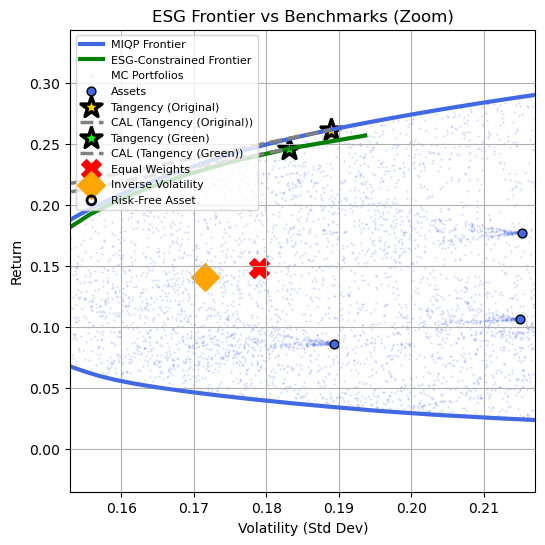

In [35]:
# -------------------------
# Zoom around tangency
# -------------------------
margin = 0.02  # increase if you want wider zoom

mask_blue  = (frontier_df["stdev"] >= tan_vol - margin) & (frontier_df["stdev"] <= tan_vol + margin)
mask_green = (frontier_esg_df["stdev"] >= tan_vol_esg - margin) & (frontier_esg_df["stdev"] <= tan_vol_esg + margin)

x_min = min(
    frontier_df.loc[mask_blue, "stdev"].min(),
    frontier_esg_df.loc[mask_green, "stdev"].min(),
    tan_vol,
    tan_vol_esg,
)

x_max = max(
    frontier_df.loc[mask_blue, "stdev"].max(),
    frontier_esg_df.loc[mask_green, "stdev"].max(),
    tan_vol,
    tan_vol_esg,
)

y_min = min(
    frontier_df.loc[mask_blue, "achieved_return"].min(),
    frontier_esg_df.loc[mask_green, "achieved_return"].min(),
    tan_ret,
    tan_ret_esg,
    rf
)

y_max = max(
    frontier_df.loc[mask_blue, "achieved_return"].max(),
    frontier_esg_df.loc[mask_green, "achieved_return"].max(),
    tan_ret,
    tan_ret_esg
)

# Add padding
pad_x = (x_max - x_min) * 0.25
pad_y = (y_max - y_min) * 0.25

xlim_zoom = (x_min - pad_x, x_max + pad_x)
ylim_zoom = (y_min - pad_y, y_max + pad_y)


# -------------------------
# Plot
# -------------------------
plot_frontier(
    title="ESG Frontier vs Benchmarks (Zoom)",
    filename="ESG_Frontier_vs_Benchmarks_Zoom.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"], "color":"royalblue", "label":"MIQP Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"], "color":"green", "label":"ESG-Constrained Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"}
    ],
    benchmarks=[
        {"vol": vol_ew, "ret": ret_ew, "color":"red", "marker":"X", "s":200, "label":"Equal Weights"},
        {"vol": vol_ivw, "ret": ret_ivw, "color":"orange", "marker":"D", "s":200, "label":"Inverse Volatility"}
    ],
    xlim=xlim_zoom,
    ylim=ylim_zoom
)


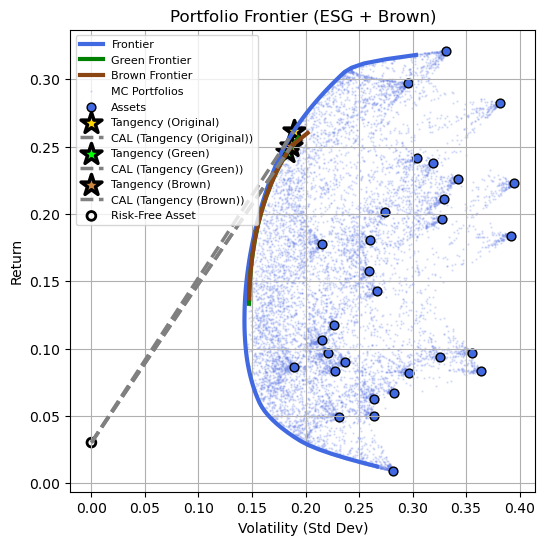

In [36]:
plot_frontier(
    title="Portfolio Frontier (ESG + Brown)",
    filename="Portfolio_Frontier_ESG_Brown.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"], "color":"royalblue", "label":"Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"], "color":"green", "label":"Green Frontier"},
        {"stdev": frontier_brown_df["stdev"], "achieved_return": frontier_brown_df["achieved_return"], "color":"saddlebrown", "label":"Brown Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"},
        {"vol": tan_vol_b, "ret": tan_ret_b, "color":"peru", "label":"Tangency (Brown)"}
    ]
)

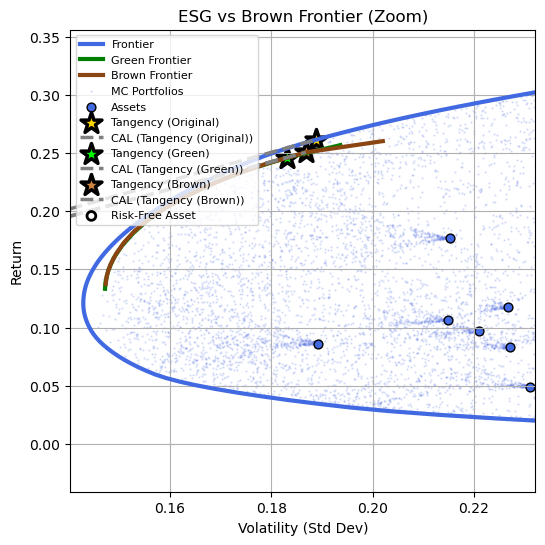

In [37]:
# -------------------------
# Zoom around tangency + small slice of frontier
# -------------------------
margin = 0.03   # increase for larger zoom, decrease for tighter zoom
pad_ratio = 0.25  # controls how much padding around the min/max

# --- slice around tangency ---
mask_blue  = (frontier_df["stdev"] >= tan_vol - margin) & (frontier_df["stdev"] <= tan_vol + margin)
mask_green = (frontier_esg_df["stdev"] >= tan_vol_esg - margin) & (frontier_esg_df["stdev"] <= tan_vol_esg + margin)
mask_brown = (frontier_brown_df["stdev"] >= tan_vol_b - margin) & (frontier_brown_df["stdev"] <= tan_vol_b + margin)

x_min = min(
    frontier_df.loc[mask_blue, "stdev"].min(),
    frontier_esg_df.loc[mask_green, "stdev"].min(),
    frontier_brown_df.loc[mask_brown, "stdev"].min(),
    tan_vol, tan_vol_esg, tan_vol_b
)

x_max = max(
    frontier_df.loc[mask_blue, "stdev"].max(),
    frontier_esg_df.loc[mask_green, "stdev"].max(),
    frontier_brown_df.loc[mask_brown, "stdev"].max(),
    tan_vol, tan_vol_esg, tan_vol_b
)

y_min = min(
    frontier_df.loc[mask_blue, "achieved_return"].min(),
    frontier_esg_df.loc[mask_green, "achieved_return"].min(),
    frontier_brown_df.loc[mask_brown, "achieved_return"].min(),
    tan_ret, tan_ret_esg, tan_ret_b,
    rf
)

y_max = max(
    frontier_df.loc[mask_blue, "achieved_return"].max(),
    frontier_esg_df.loc[mask_green, "achieved_return"].max(),
    frontier_brown_df.loc[mask_brown, "achieved_return"].max(),
    tan_ret, tan_ret_esg, tan_ret_b
)

# Add padding
pad_x = (x_max - x_min) * pad_ratio
pad_y = (y_max - y_min) * pad_ratio

xlim_zoom = (x_min - pad_x, x_max + pad_x)
ylim_zoom = (y_min - pad_y, y_max + pad_y)


# -------------------------
# Plot
# -------------------------
plot_frontier(
    title="ESG vs Brown Frontier (Zoom)",
    filename="Portfolio_Frontier_ESG_Brown_Zoom.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"], "color":"royalblue", "label":"Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"], "color":"green", "label":"Green Frontier"},
        {"stdev": frontier_brown_df["stdev"], "achieved_return": frontier_brown_df["achieved_return"], "color":"saddlebrown", "label":"Brown Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"},
        {"vol": tan_vol_b, "ret": tan_ret_b, "color":"peru", "label":"Tangency (Brown)"}
    ],
    xlim=xlim_zoom,
    ylim=ylim_zoom
)


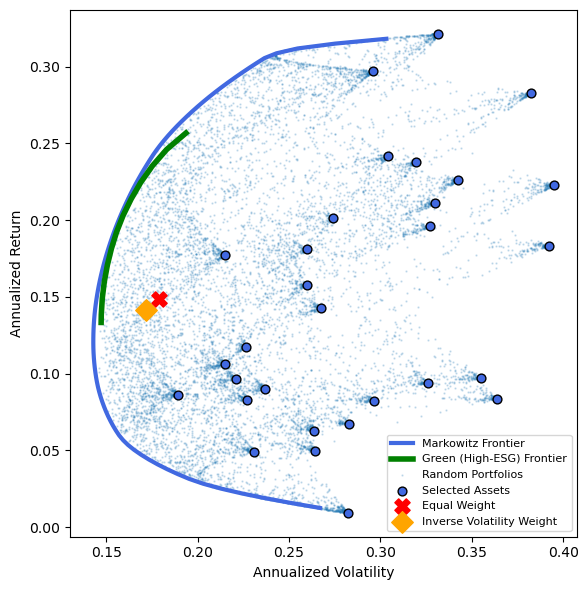

In [38]:
# -------------------------------------------------
# Benchmarks (TOPSIS-selected universe)
# -------------------------------------------------

# Equal-weight portfolio
n_assets = len(mu_sel)
w_ew = np.ones(n_assets) / n_assets
ret_ew = float(mu_sel.values @ w_ew)
vol_ew = float(np.sqrt(w_ew @ (df_cov_sel.values * 252) @ w_ew))

# Inverse-volatility-weighted portfolio
asset_vols = df_return_sel.std(axis=0).values * np.sqrt(252)
inv_vol = 1.0 / asset_vols
w_ivw = inv_vol / inv_vol.sum()

ret_ivw = float(mu_sel.values @ w_ivw)
vol_ivw = float(np.sqrt(w_ivw @ (df_cov_sel.values * 252) @ w_ivw))

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(6, 6))

# Efficient frontiers
plt.plot(
    frontier_df["stdev"],
    frontier_df["achieved_return"],
    color="royalblue",
    linewidth=3,
    label="Markowitz Frontier"
)

plt.plot(
    frontier_esg_df["stdev"],
    frontier_esg_df["achieved_return"],
    color="green",
    linewidth=4,
    label="Green (High-ESG) Frontier"
)

# Random portfolios cloud
plt.scatter(
    port_df["Volatility"],
    port_df["Return"],
    s=0.5,
    alpha=0.2,
    label="Random Portfolios"
)

# Individual assets
plt.scatter(
    asset_stdevs,
    asset_returns,
    facecolors="royalblue",
    edgecolors="k",
    linewidths=1,
    s=40,
    label="Selected Assets"
)

# Benchmarks
plt.scatter(
    vol_ew,
    ret_ew,
    c="red",
    marker="X",
    s=120,
    label="Equal Weight"
)

plt.scatter(
    vol_ivw,
    ret_ivw,
    c="orange",
    marker="D",
    s=120,
    label="Inverse Volatility Weight"
)

# Labels & layout
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.legend(loc="best", fontsize=8)
plt.tight_layout()

plt.savefig(
    "AHP/ESG_Frontier_vs_Benchmarks.png",
    dpi=144,
    transparent=True
)

plt.show()


In [39]:
def parse_weights(w):
    if isinstance(w, str):
        return np.fromstring(w.strip("[]"), sep=" ")
    elif isinstance(w, (list, np.ndarray)):
        return np.array(w, dtype=float)
    else:
        raise ValueError(f"Unexpected weights type: {type(w)}")

def expand_frontier(df_in, asset_cols, out_path):
    """
    Expands a frontier DataFrame by unpacking portfolio weights
    into individual asset columns.
    """
    # Extract weight matrix
    wmat = np.vstack(df_in["weights"].apply(parse_weights).to_numpy())

    # Safety check
    if wmat.shape[1] != len(asset_cols):
        raise ValueError(
            f"Weight dimension mismatch: "
            f"{wmat.shape[1]} weights vs {len(asset_cols)} asset columns"
        )

    # Build expanded DataFrame
    wdf = pd.DataFrame(wmat, columns=asset_cols, index=df_in.index)
    df_out = pd.concat([df_in.drop(columns=["weights"]), wdf], axis=1)

    # Save
    df_out.to_csv(out_path, index=False)
    return df_out

asset_cols = df_return_sel.columns.tolist()

frontier_expanded = expand_frontier(
    frontier_df,
    asset_cols,
    "AHP/frontier_markowitz_expanded.csv"
)

frontier_esg_expanded = expand_frontier(
    frontier_esg_df,
    asset_cols,
    "AHP/frontier_green_expanded.csv"
)

frontier_brown_expanded = expand_frontier(
    frontier_brown_df,
    asset_cols,
    "AHP/frontier_brown_expanded.csv"
)


In [40]:
# -------------------------------------------------
# Export expanded frontiers (project-consistent)
# -------------------------------------------------

frontier_expanded.to_csv(
    "AHP/frontier_markowitz_expanded.csv",
    index=False
)

frontier_esg_expanded.to_csv(
    "AHP/frontier_green_expanded.csv",
    index=False
)

frontier_brown_expanded.to_csv(
    "AHP/frontier_brown_expanded.csv",
    index=False
)


In [41]:
# ============================================================
# Tangency Portfolios (Maximum Sharpe Ratio)
# ============================================================
import os
rf = 0.00012 *252  # annualized risk-free rate (keep consistent)

asset_cols = df_return_sel.columns.tolist()
os.makedirs("AHP/Tangency", exist_ok=True)

def scalarize(x):
    """Convert arrays/lists to a single scalar float."""
    arr = np.array(x).ravel()
    if arr.size == 0:
        return np.nan
    return float(arr[0])

def vectorize_weights(w):
    """Convert weights to 1D numpy array."""
    if isinstance(w, str):
        w = w.strip("[]")
        w = np.array(w.split(), dtype=float)
    else:
        w = np.array(w).ravel()
    return w.astype(float)

def compute_tangency(frontier_df, rf):
    df = frontier_df.copy()

    # Force scalar values
    df["stdev"] = pd.to_numeric(df["stdev"], errors="coerce")
    df["achieved_return"] = pd.to_numeric(df["achieved_return"], errors="coerce")

    # Compute Sharpe
    df["sharpe"] = (df["achieved_return"] - rf) / df["stdev"]

    # ONLY clean sharpe column (no replace on full df)
    df = df[np.isfinite(df["sharpe"])]

    idx = df["sharpe"].idxmax()

    w = vectorize_weights(df.loc[idx, "weights"])
    ret = float(df.loc[idx, "achieved_return"])
    vol = float(df.loc[idx, "stdev"])
    sharpe = float(df.loc[idx, "sharpe"])

    return w, ret, vol, sharpe


# ------------------------------------------------------------
# Tangency portfolios
# ------------------------------------------------------------
tan_w, tan_ret, tan_vol, tan_sharpe = compute_tangency(frontier_df, rf)
tan_w_esg, tan_ret_esg, tan_vol_esg, tan_sharpe_esg = compute_tangency(frontier_esg_df, rf)
tan_w_b, tan_ret_b, tan_vol_b, tan_sharpe_b = compute_tangency(frontier_brown_df, rf)

# ------------------------------------------------------------
# Export weights
# ------------------------------------------------------------
pd.DataFrame({"asset": asset_cols, "weight": tan_w}).to_csv(
    "AHP/Tangency/tangency_markowitz_weights.csv", index=False)

pd.DataFrame({"asset": asset_cols, "weight": tan_w_esg}).to_csv(
    "AHP/Tangency/tangency_green_weights.csv", index=False)

pd.DataFrame({"asset": asset_cols, "weight": tan_w_b}).to_csv(
    "AHP/Tangency/tangency_brown_weights.csv", index=False)

# ------------------------------------------------------------
# Export summaries
# ------------------------------------------------------------
summary_df = pd.DataFrame([
    {"frontier": "markowitz", "rf": rf, "return": tan_ret, "volatility": tan_vol, "sharpe": tan_sharpe},
    {"frontier": "green",     "rf": rf, "return": tan_ret_esg, "volatility": tan_vol_esg, "sharpe": tan_sharpe_esg},
    {"frontier": "brown",     "rf": rf, "return": tan_ret_b, "volatility": tan_vol_b, "sharpe": tan_sharpe_b}
])

summary_df.to_csv("AHP/Tangency/tangency_summary.csv", index=False)


In [42]:
import matplotlib.pyplot as plt

def plot_frontier(
    title,
    filename,
    frontiers,
    mc_df,
    asset_returns,
    asset_stdevs,
    rf,
    tangencies,
    benchmarks=None,
    xlim=None,
    ylim=None,
    figsize=(6,6)
):
    plt.figure(figsize=figsize)

    # Plot frontiers
    for f in frontiers:
        plt.plot(
            f["stdev"],
            f["achieved_return"],
            linewidth=f.get("lw", 3),
            color=f["color"],
            label=f["label"]
        )

    # MC portfolios
    plt.scatter(
        mc_df["Volatility"], mc_df["Return"],
        s=0.5, c='#6881E7', alpha=0.2, label="MC Portfolios"
    )

    # Assets
    plt.scatter(
        asset_stdevs, asset_returns,
        facecolors='royalblue', edgecolors='k',
        linewidths=1, s=40, label="Assets"
    )

    # Tangency points and CAL
    for t in tangencies:
        plt.scatter(
            t["vol"], t["ret"],
            c=t["color"], edgecolors='k', marker='*',
            s=t.get("size", 250), linewidths=2.5, label=t["label"]
        )
        plt.plot(
            [0, t["vol"]],
            [rf, t["ret"]],
            linestyle='--',
            color='gray',
            linewidth=2.5,
            label=f'CAL ({t["label"]})'
        )

    # Benchmarks
    if benchmarks:
        for b in benchmarks:
            plt.scatter(
                b["vol"], b["ret"],
                c=b["color"],
                marker=b["marker"],
                s=b["s"],
                label=b["label"]
            )

    plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40,
                linewidths=2, label='Risk-Free Asset')

    plt.title(title)
    plt.xlabel("Volatility (Std Dev)")
    plt.ylabel("Return")
    plt.grid(True)

    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)

    plt.legend(loc='best', fontsize=8)
    plt.savefig(f"AHP/{filename}", dpi=144, transparent=True)
    plt.show()


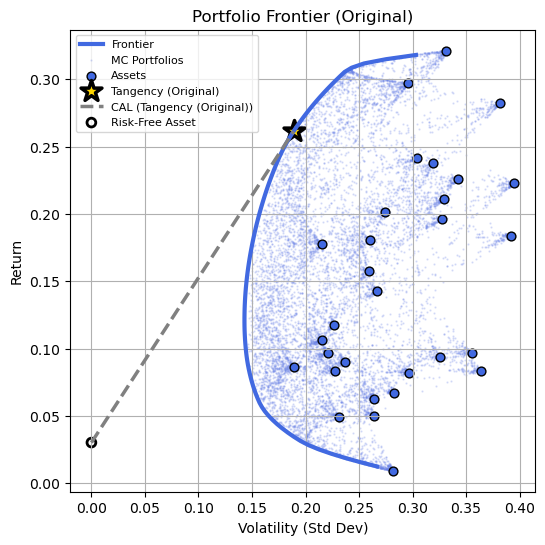

In [43]:
plot_frontier(
    title="Portfolio Frontier (Original)",
    filename="Portfolio_Frontier.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"],
         "color":"royalblue", "label":"Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"}
    ]
)


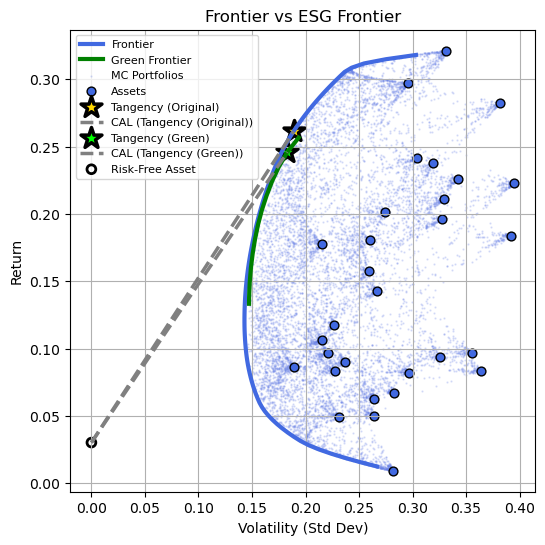

In [44]:
plot_frontier(
    title="Frontier vs ESG Frontier",
    filename="Portfolio_Frontier_ESG.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"],
         "color":"royalblue", "label":"Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"],
         "color":"green", "label":"Green Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"}
    ]
)


In [45]:
def compute_metrics(returns, rf=0.00012):
    returns = pd.Series(returns).dropna()

    if len(returns) < 2:
        return {k: np.nan for k in [
            "annual_return","volatility","sharpe","sortino",
            "max_drawdown","calmar","cvar_95","rachev_95"
        ]}

    ann_factor = 252
    mean_ret = returns.mean() * ann_factor
    vol = returns.std(ddof=1) * np.sqrt(ann_factor)

    sharpe = (mean_ret - rf) / vol if vol != 0 else np.nan

    downside = returns[returns < 0]
    downside_std = downside.std(ddof=1) * np.sqrt(ann_factor)
    sortino = (mean_ret - rf) / downside_std if downside_std != 0 else np.nan

    # Max Drawdown
    cum = (1 + returns).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    max_dd = drawdown.min()
    calmar = mean_ret / abs(max_dd) if max_dd != 0 else np.nan

    # CVaR 95% and Rachev
    alpha = 0.05
    var = returns.quantile(alpha)
    cvar = returns[returns <= var].mean()
    ES = returns[returns <= var].sum()

    up_var = returns.quantile(1-alpha)
    cvar_up = returns[returns >= up_var].mean()

    rachev = cvar_up / abs(cvar) if cvar != 0 else np.nan

    return {
        "annual_return": mean_ret,
        "volatility": vol,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_drawdown": max_dd,
        "calmar": calmar,
        "ES_95": ES,
        "rachev_95": rachev
    }


In [46]:
def portfolio_returns(weights, asset_returns_df):
    weights = np.array(weights).flatten()

    # asset_returns_df must be DataFrame with shape (n_days, n_assets)
    if asset_returns_df.shape[1] != len(weights):
        raise ValueError(
            f"Mismatch: asset_returns has {asset_returns_df.shape[1]} columns but weights length is {len(weights)}"
        )

    return asset_returns_df @ weights


In [47]:
ret_tan = portfolio_returns(tan_w, df_return_sel)
ret_tan_esg = portfolio_returns(tan_w_esg, df_return_sel)
ret_tan_brown = portfolio_returns(tan_w_b, df_return_sel)

metrics_tan = compute_metrics(ret_tan, rf=rf)
metrics_tan_esg = compute_metrics(ret_tan_esg, rf=rf)
metrics_tan_brown = compute_metrics(ret_tan_brown, rf=rf)

print(metrics_tan)
print(metrics_tan_esg)
print(metrics_tan_brown)


{'annual_return': 0.26141704150146294, 'volatility': 0.18885948302344766, 'sharpe': 1.2240690157600473, 'sortino': 1.6048027072950104, 'max_drawdown': -0.2724674930755015, 'calmar': 0.9594430460334714, 'ES_95': -3.2201659214742433, 'rachev_95': 1.0269788406878122}
{'annual_return': 0.2459882742704761, 'volatility': 0.18305432519321765, 'sharpe': 1.1786024397006152, 'sortino': 1.4990310074302025, 'max_drawdown': -0.29223346529605854, 'calmar': 0.8417525830632301, 'ES_95': -3.1833616461260363, 'rachev_95': 0.976854741336339}
{'annual_return': 0.25056025747950617, 'volatility': 0.18683299689488905, 'sharpe': 1.1792363294555341, 'sortino': 1.502511319038396, 'max_drawdown': -0.29494941245605577, 'calmar': 0.8495024804188647, 'ES_95': -3.251156610071476, 'rachev_95': 0.9721776676835636}


In [48]:
df_metrics = pd.DataFrame([
    {"Portfolio": "Tangency", **metrics_tan},
    {"Portfolio": "Tangency ESG", **metrics_tan_esg},
    {"Portfolio": "Tangency Brown", **metrics_tan_brown}
])

df_metrics.to_csv('AHP/AHP_portfolio_metrics.csv', index=False)

In [49]:
df_metrics

,Portfolio,annual_return,volatility,sharpe,sortino,max_drawdown,calmar,ES_95,rachev_95
0,Tangency,0.261417,0.188859,1.224069,1.604803,-0.272467,0.959443,-3.220166,1.026979
1,Tangency ESG,0.245988,0.183054,1.178602,1.499031,-0.292233,0.841753,-3.183362,0.976855
2,Tangency Brown,0.250560,0.186833,1.179236,1.502511,-0.294949,0.849502,-3.251157,0.972178
